In [ ]:
##Magick Downloaded (Used in Bash/Command Line)
cd ImagesforModelTraining\LM19\
magick mogrify -format jpg LM19*.tif
## Change color 
magick LM19*.jpg -colorspace Gray LM19*BW.jpg
##Repeat for LM20
cd . 
cd LM20 
 magick mogrify -format jpg LM20*.tif
 magick LM20*.jpg -colorspace Gray LM20*BW.jpg

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [24]:
data_dir = "C:/Users/cccsm/praccomp2024/FinalProject/ImagesforModelTraining/ModelImages"
pathlib.Path(data_dir).with_suffix('')

WindowsPath('C:/Users/cccsm/praccomp2024/FinalProject/ImagesforModelTraining/ModelImages')

In [25]:
batch_size = 4 ## Should we do 1 at a time?
img_height = 1024
img_width = 1024

In [26]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 24 files belonging to 2 classes.
Using 20 files for training.


In [27]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 24 files belonging to 2 classes.
Using 4 files for validation.


In [28]:
class_names = train_ds.class_names
print(class_names)

['LM19', 'LM20']


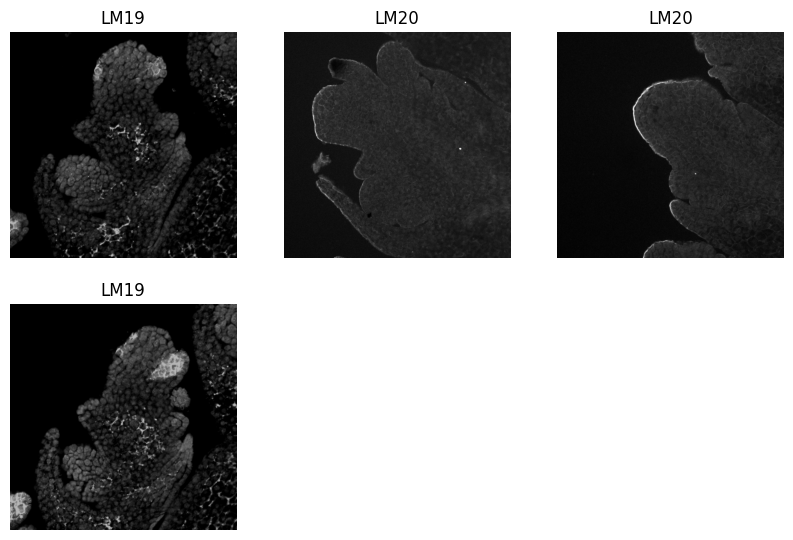

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(4): ##change range from 9-4; based on Batch size
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [30]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(4, 1024, 1024, 3)
(4,)


In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [32]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.7372549


In [33]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

C:\Users\cccsm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary() 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 1024, 1024, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 1024, 1024, 16) │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 512, 512, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 512, 512, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 256, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1048576)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │   134,217,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,241,698 (512.09 MB)

 Trainable params: 134,241,698 (512.09 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7090 - loss: 3.9010 - val_accuracy: 0.5000 - val_loss: 2.3829
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 915ms/step - accuracy: 0.8326 - loss: 0.8256 - val_accuracy: 0.5000 - val_loss: 2.6647
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 840ms/step - accuracy: 0.8076 - loss: 0.5245 - val_accuracy: 0.5000 - val_loss: 1.4498
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 799ms/step - accuracy: 0.8965 - loss: 0.0930 - val_accuracy: 0.5000 - val_loss: 1.3598
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 882ms/step - accuracy: 1.0000 - loss: 0.0613 - val_accuracy: 0.5000 - val_loss: 1.3830
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 881ms/step - accuracy: 1.0000 - loss: 0.0221 - val_accuracy: 0.5000 - val_loss: 1.5816
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 847ms/step - accuracy: 1.0000 - loss: 0.0192 - val_accuracy: 0.5000 - val_loss: 2.7592
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 893ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.5000 - val_loss: 3.

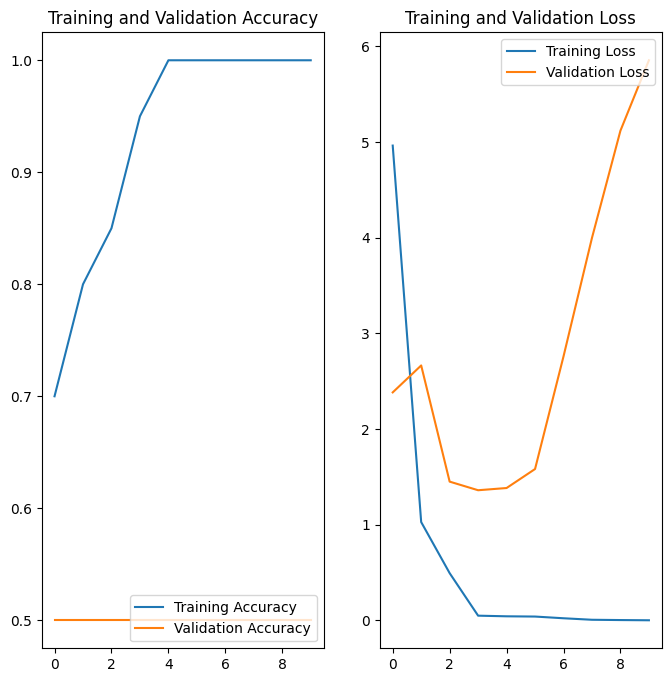

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Augment the Data itself - (Flip/Reverse to give multiple data points from the same image - looking from "different perspectives")

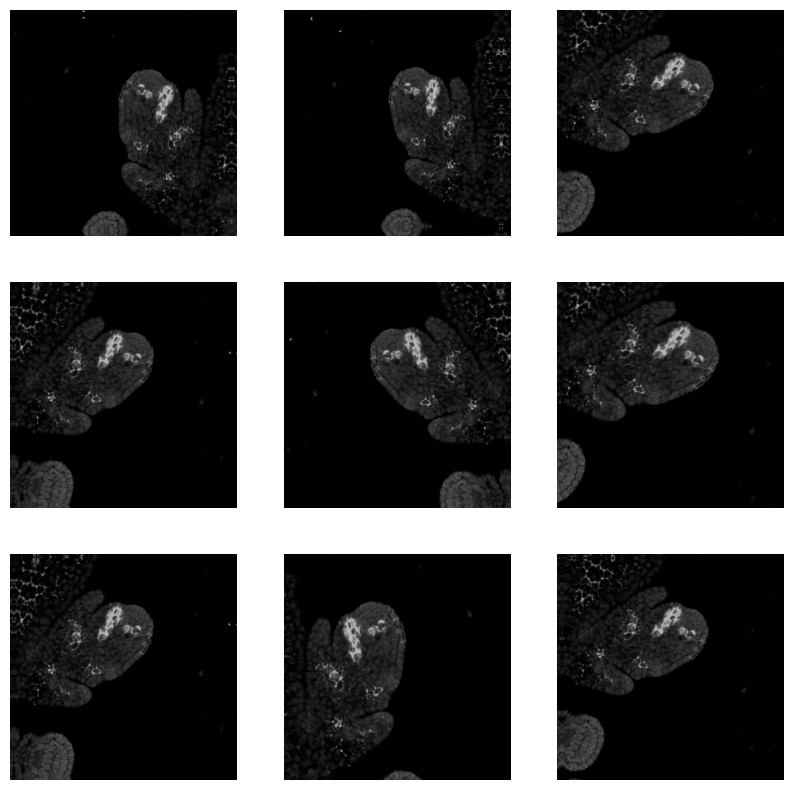

In [38]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Data Dropout for Fine Tuning - 

In [39]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 1024, 1024, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 1024, 1024, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 1024, 1024, 16) │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 512, 512, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 512, 512, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 256, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1048576)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │   134,217,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,241,698 (512.09 MB)

 Trainable params: 134,241,698 (512.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 935ms/step - accuracy: 0.6201 - loss: 3.2431 - val_accuracy: 0.5000 - val_loss: 1.0825
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 899ms/step - accuracy: 0.5514 - loss: 1.4354 - val_accuracy: 0.5000 - val_loss: 0.7910
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 980ms/step - accuracy: 0.7646 - loss: 0.4372 - val_accuracy: 0.2500 - val_loss: 0.8197
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 977ms/step - accuracy: 0.8368 - loss: 0.3433 - val_accuracy: 0.2500 - val_loss: 1.1362
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 987ms/step - accuracy: 0.8118 - loss: 0.3285 - val_accuracy: 0.5000 - val_loss: 1.1605
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 990ms/step - accuracy: 0.9319 - loss: 0.1378 - val_accuracy: 0.5000 - val_loss: 1.5367
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 990ms/step - accuracy: 1.0000 - loss: 0.0851 - val_accuracy: 0.5000 - val_loss: 2.0701
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 963ms/step - accuracy: 1.0000 - loss: 0.0332 - val_accuracy: 0.5000 - val_loss:

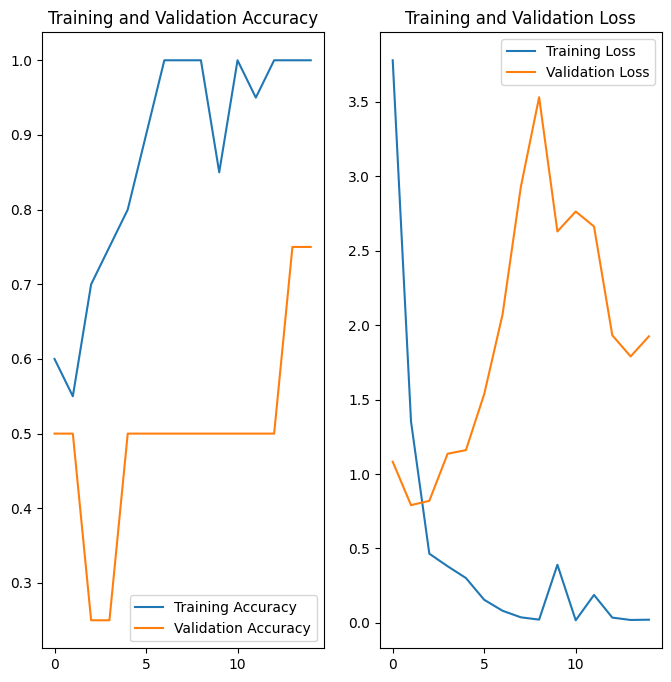

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Testing with new images

In [ ]:
##Tranforming Images 
##cd directory with new images
#magick mogrify -format jpg Test*.tif #images were names Test*.tif
##to list contents of directory 
#dir 
##remove the tifs and keep the jpgs 
#del *.tif
##Convert to grayscale (Do for each file)
#magick TestLM20.jpg -colorspace Gray TestLM20BW.jpg
##Resizing Test Images 
#magick TestLM20cBW.jpg -resize 1024x1024 NTestLM20cBW.jpg 

In [42]:
LM20_path = "C:/Users/cccsm/praccomp2024/FinalProject/TestImages/NTestLM20bBW.jpg"
img = tf.keras.utils.load_img(
    LM20_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
This image most likely belongs to LM20 with a 84.97 percent confidence.


In [43]:
LM20_path = "C:/Users/cccsm/praccomp2024/FinalProject/TestImages/NTestLM20aBW.jpg"
img = tf.keras.utils.load_img(
    LM20_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
This image most likely belongs to LM20 with a 85.89 percent confidence.


In [44]:
LM20_path = "C:/Users/cccsm/praccomp2024/FinalProject/TestImages/NTestLM20cBW.jpg"
img = tf.keras.utils.load_img(
    LM20_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
This image most likely belongs to LM20 with a 99.67 percent confidence.


In [47]:
LM20_path = "C:/Users/cccsm/praccomp2024/FinalProject/TestImages/NTestLM19aBW.jpg"
img = tf.keras.utils.load_img(
    LM20_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
This image most likely belongs to LM20 with a 99.95 percent confidence.
